In [1]:
import numpy as np
import pandas as pd
import random
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


#### The info_gain() function using entropy() or gini()

In [2]:
def gini(labels: np.ndarray):
    gini_val = 0
    label_freq = {}
    for i in labels:
        if i in label_freq: label_freq[i] += 1
        else: label_freq[i] = 1

    for i in label_freq:
        gini_val += (label_freq[i] / len(labels)) ** 2

    return 1 - gini_val

def entropy(labels: np.ndarray):
    entropy_val = 0
    label_freq = {}
    for i in labels:
        if i in label_freq: label_freq[i] += 1
        else: label_freq[i] = 1
    for i in label_freq:
        prob = label_freq[i] / len(labels)
        if prob == 0:
            continue
        else:entropy_val += -((prob) * np.log2(prob))


    return entropy_val

def info_gain(par, left, right, func=entropy):
    return func(par) - (((len(left) / len(par)) * func(left)) + ((len(right) / len(par)) * func(right)))

### The Node class

In [3]:
class Node:
    def __init__(self, feature=None, left=None, right=None, value=None, ig=None, threshold=None) -> None:
        self.feature = feature
        self.left = left
        self.right = right
        # self.ig = ig #information gain
        self.value = value
        self.threshold = threshold
        

### The Decision Tree class

In [4]:
class DT:
    def __init__(self, func, feats_to_split, max_depth=None, majority_limit=None, min_samples=None) -> None:
        self.func = func
        self.feats_to_split = feats_to_split
        self.depth = 0
        self.max_depth = max_depth
        self.majority_limit = majority_limit
        self.min_samples = min_samples

    def fit(self, x_train, y_train):
        self.tree = self.build(x_train, y_train.astype(int), self.feats_to_split)

    def best_split(self, x_train, y_train, feats_to_split):
        best_info_val = 0
        best_feature_ind = None
        best_threshold = None
        curr_info_val = 0
        for feature in feats_to_split:
            for threshold in np.unique(x_train[:, feature]):
                left_ind, right_ind = x_train[:, feature] < threshold, x_train[:, feature] >= threshold
                left, right = y_train[left_ind], y_train[right_ind]
                curr_info_val = info_gain(y_train, left, right, self.func)
                # print(info_gain(y_train, left, right, self.func))
                if curr_info_val >= best_info_val:
                    best_info_val = curr_info_val
                    best_feature_ind = feature
                    best_threshold = threshold
        return best_feature_ind, best_threshold

    def build(self, x_train, y_train, feats_to_split, prev_y_train=None):
        self.depth += 1
        # print(f"Depth: {self.depth}")
        # print(f"X_train: {x_train}")
        samples_count = len(x_train)

        if samples_count == 0:
            return Node(value=np.argmax(np.bincount(prev_y_train)))

        if len(set(y_train)) == 1:
            return Node(value=y_train[0])
        
        if self.min_samples != None and samples_count < self.min_samples:
            return Node(value=np.argmax(np.bincount(y_train)))
        
        if self.max_depth != None and self.depth > self.max_depth:
            return Node(value=np.argmax(np.bincount(y_train)))

        
        label_freqs = np.array(np.bincount(y_train))
        percent_major = np.max(label_freqs) / np.sum(label_freqs)
        major_class = np.argmax(label_freqs)

        if self.majority_limit != None and percent_major >= self.majority_limit:
            return Node(value=major_class)

        best_feature_ind, best_threshold = self.best_split(x_train, y_train, random.sample(list(feats_to_split), int(np.sqrt(len(feats_to_split)))))
        best_threshold = np.mean(x_train[:, best_feature_ind])
        # print(f"Best Feature: {best_feature_ind}, Best Threshold: {best_threshold}")
        if best_feature_ind == None:
            return Node(value=major_class)
        
        left_inds = x_train[:, best_feature_ind] < best_threshold
        right_inds = x_train[:, best_feature_ind] >= best_threshold
        
        prev_y_train = y_train
        if len(left_inds) > 0:
            left_tree = self.build(x_train[left_inds], y_train[left_inds], feats_to_split, y_train)
        else:
            left_tree = None
        if len(right_inds) > 0:
            right_tree = self.build(x_train[right_inds], y_train[right_inds], feats_to_split, y_train)
        else:
            right_tree = None
        return Node(feature=best_feature_ind, left=left_tree, right=right_tree, threshold=best_threshold)

    def predict_helper(self, x_input, node:Node):
        if node.value is not None:
            return node.value
        if x_input[node.feature] < node.threshold:
            return self.predict_helper(x_input, node.left)
        if x_input[node.feature] >= node.threshold:
            return self.predict_helper(x_input, node.right)

    def predict(self, x_train):
        return np.array([self.predict_helper(x_input, self.tree) for x_input in x_train])

    def accuracy(self, actual, preds):
        return (np.sum(actual == preds) / len(actual)) * 100


### Functions to split the dataset

In [5]:
def split_by_class(x_train: np.ndarray, y_train: np.ndarray)->np.ndarray:
    classes = np.unique(y_train)
    x_split_data = [x_train[y_train == label] for label in classes]
    y_split_data = [y_train[y_train == label] for label in classes]
    return x_split_data, y_split_data

def k_splits(k: int, x_train: np.ndarray, y_train:np.ndarray):
    fold_size = len(x_train) / k #Size of each fold
    k_folds_x, k_folds_y = [], [] #List to store the k folds
    x_train_by_class, y_split_data = split_by_class(x_train, y_train) #Split the data by class
    class_size_in_each_fold = [int(fold_size * (len(subset) / len(x_train))) for subset in x_train_by_class] #Proportion of each class in the data
    for i in range(k):
        fold_x, fold_y = [], []
        for j in range(len(x_train_by_class)):
            fold_x.extend(x_train_by_class[j][i * class_size_in_each_fold[j] : (i + 1) * class_size_in_each_fold[j]])
            fold_y.extend(y_split_data[j][i * class_size_in_each_fold[j] : (i + 1) * class_size_in_each_fold[j]])
        k_folds_x.append(fold_x)
        k_folds_y.append(fold_y)
    
    #while there are still data points left, add them evenly to the folds
    if len(k_folds_x[0]) < int(fold_size):
        for i in range(k):
            k_folds_x[i].append(x_train[-(i + 1)])
            k_folds_y[i].append(y_train[-(i + 1)])
    
    return np.array(k_folds_x), np.array(k_folds_y)


### The Random Forest Classifier class

In [6]:
class RandomForest:
    def __init__(self, n_trees: int, feats_to_split:list, labels:list, max_depth: int=None, majority_limit: float=None, min_samples: int=None):
        self.n_trees = n_trees
        self.feats_to_split = feats_to_split
        self.decision_trees = []
        self.labels = labels
        self.max_depth = max_depth
        self.majority_limit = majority_limit
        self.min_samples = min_samples
    
    def fit(self, x_train: np.ndarray, y_train: np.ndarray, func)->None:
        for i in range(self.n_trees):
            curr_tree = DT(func, self.feats_to_split, max_depth=self.max_depth, majority_limit=self.majority_limit, min_samples=self.min_samples)
            bootstrap_indices = np.random.choice(len(x_train), len(x_train), replace=True)
            curr_tree.fit(x_train[bootstrap_indices], y_train[bootstrap_indices])
            self.decision_trees.append(curr_tree)
    
    def predict(self, X: np.ndarray)->np.ndarray:
        preds = np.array([tree.predict(X) for tree in self.decision_trees])
        return np.array([np.argmax(np.bincount(preds[:, i])) for i in range(len(X))])
    
    def accuracy(self, Y: np.ndarray, preds: np.ndarray)->float:
        return (np.sum(Y == preds) / len(Y))
    
    def precision(self, Y: np.ndarray, preds: np.ndarray)->float:
        precs = []
        for positive_label in self.labels:
            positive_label_weight = np.sum(Y == positive_label) / len(Y)
            TP = np.sum((Y == positive_label) & (preds == positive_label))
            FP = np.sum((Y != positive_label) & (preds == positive_label))
            precs.append((TP * positive_label_weight) / (TP + FP) if (TP + FP) != 0 else 0)
        return np.sum(np.array(precs))
        
    
    def recall(self, Y: np.ndarray, preds: np.ndarray)->float:
        recs = []
        for positive_label in self.labels:
            positive_label_weight = np.sum(Y == positive_label) / len(Y)
            TP = np.sum((Y == positive_label) & (preds == positive_label))
            FN = np.sum((Y == positive_label) & (preds != positive_label))
            recs.append(TP * positive_label_weight / (TP + FN) if (TP + FN) != 0 else 0)
        return np.sum(np.array(recs))
    
    def f1_score(self, Y: np.ndarray, preds: np.ndarray)->float:
        # f1s = []
        precision = self.precision(Y, preds)
        recall = self.recall(Y, preds)
        f1 = 2 * ((precision * recall) / (precision + recall))
        # f1s.append(f1)
        return f1
    
    def true_positives(self, Y: np.ndarray, preds: np.ndarray, target_label)->int:
        return np.sum((Y == target_label) & (preds == target_label))
        # return 0
    
    def true_negatives(self, Y: np.ndarray, preds: np.ndarray, target_label)->int:
        return np.sum((Y != target_label) & (preds != target_label))
        # return 0
    

### Training the random Forest (Wine dataset)

In [7]:
train_data = pd.read_csv('hw3_wine.csv', delimiter='\t')
x_train, y_train = train_data.iloc[:, 1:].values, train_data.iloc[:, 0].values
y_train = y_train.astype(int)

k = 10

avg_acc_arr = []
avg_prec_arr = []
avg_recall_arr = []
avg_f1_arr = []

x_axis = [1, 5, 10, 20, 30, 40, 50]

for n in x_axis:
    k_folds_x, k_folds_y = k_splits(k, x_train, y_train)
    acc_arr = []
    prec_arr = []
    recall_arr = []
    f1_arr = []

    for i in range(k):
        x_train = np.array([x for j, x in enumerate(k_folds_x) if j != i])
        y_train = np.array([y for j, y in enumerate(k_folds_y) if j != i])
        x_train = np.concatenate(x_train)
        y_train = np.concatenate(y_train)
        x_test = k_folds_x[i]
        y_test = k_folds_y[i]
        rf = RandomForest(n, [i for i in range(13)], [1, 2, 3], min_samples=5, max_depth=50)
        rf.fit(x_train, y_train, entropy)
        preds = rf.predict(x_test)
        acc_arr.append(rf.accuracy(y_test, preds))
        prec_arr.append(rf.precision(y_test, preds))
        recall_arr.append(rf.recall(y_test, preds))
        f1_arr.append(rf.f1_score(y_test, preds))
    
    avg_acc_arr.append(np.mean(acc_arr))
    avg_prec_arr.append(np.mean(prec_arr))
    avg_recall_arr.append(np.mean(recall_arr))
    avg_f1_arr.append(np.mean(f1_arr))

plt.plot(x_axis, avg_acc_arr, label='Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Wine-entropy-accuracy')
plt.savefig('wine_entropy_accuracy.png')
plt.show()

plt.plot(x_axis, avg_prec_arr, label='Precision')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Wine-entropy-precision')
plt.savefig('wine_entropy_precision.png')
plt.show()

plt.plot(x_axis, avg_recall_arr, label='Recall')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Wine-entropy-recall')
plt.savefig('wine_entropy_recall.png')
plt.show()

plt.plot(x_axis, avg_f1_arr, label='F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Wine-entropy-f1')
plt.savefig('wine_entropy_f1.png')
plt.show()

plt.plot(x_axis, avg_acc_arr, label='Accuracy')
plt.plot(x_axis, avg_prec_arr, label='Precision')
plt.plot(x_axis, avg_recall_arr, label='Recall')
plt.plot(x_axis, avg_f1_arr, label='F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.title('Wine-entropy-all')
plt.savefig('wine_entropy_all.png')
plt.show()
print(avg_acc_arr)
print(avg_prec_arr)
print(avg_recall_arr)
print(avg_f1_arr)




KeyboardInterrupt: 

### The Voting Dataset

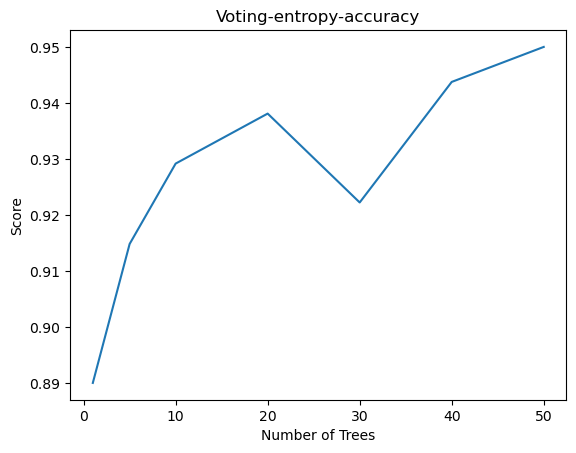

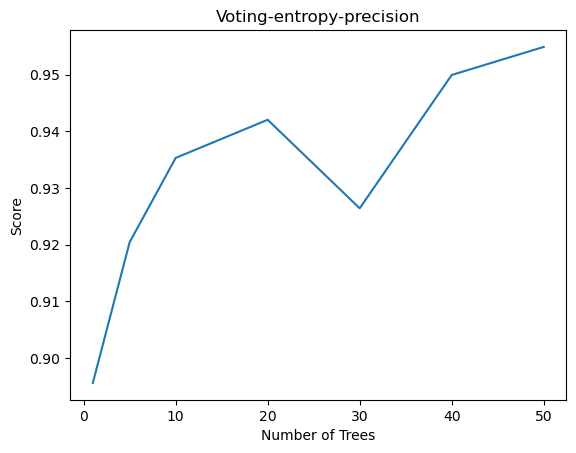

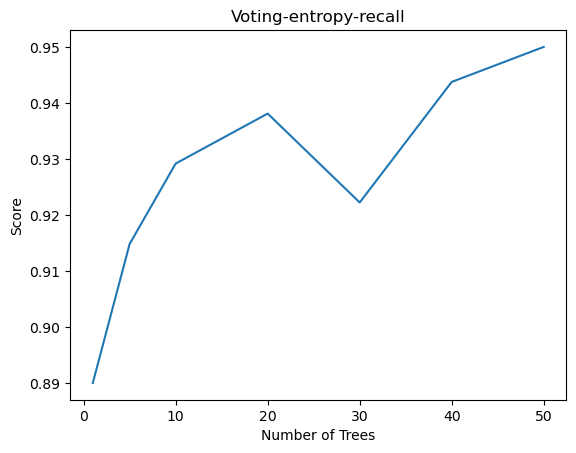

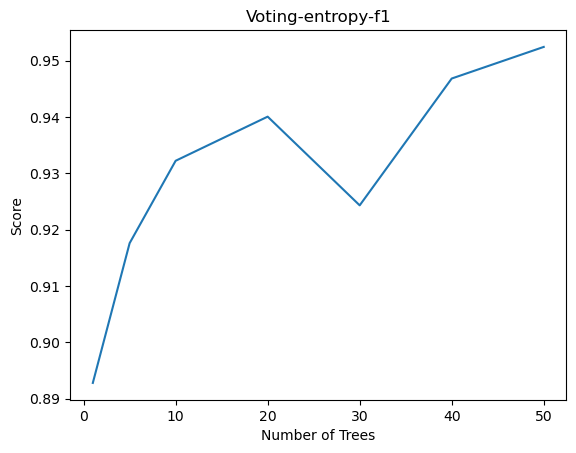

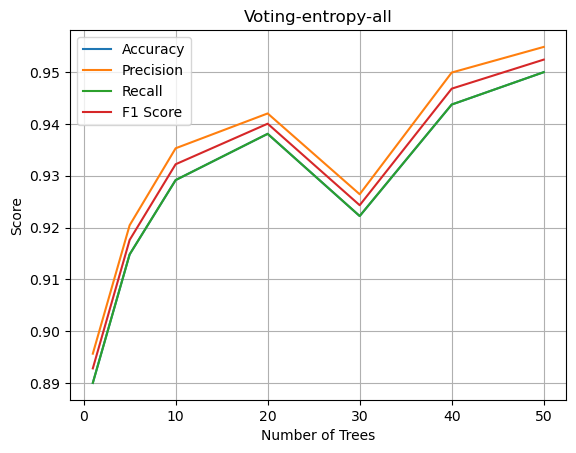

[0.89, 0.9148148148148149, 0.9291666666666668, 0.9380952380952381, 0.9222222222222222, 0.94375, 0.95]
[0.8956470229117288, 0.9204378845555314, 0.9353059440559441, 0.942031302031302, 0.9264309764309765, 0.9499289772727273, 0.954875283446712]
[0.8900000000000002, 0.9148148148148145, 0.9291666666666668, 0.9380952380952381, 0.9222222222222222, 0.94375, 0.95]
[0.8928032821262348, 0.9176023443661572, 0.9322224147765059, 0.9400523881270744, 0.9243130562308084, 0.9468165674501664, 0.9524248011028618]


In [12]:
voting_data = pd.read_csv('hw3_house_votes_84.csv')
train_data, test_data = train_test_split(voting_data, test_size=0.3, random_state=42)
x_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
x_test, y_test = test_data.iloc[:, -1:].values, test_data.iloc[:, -1].values


k = 10

avg_acc_arr = []
avg_prec_arr = []
avg_recall_arr = []
avg_f1_arr = []

x_axis = [1, 5, 10, 20, 30, 40, 50]

for n in [1, 5, 10, 20, 30, 40, 50]:
    k_folds_x, k_folds_y = k_splits(k, x_train, y_train)
    acc_arr = []
    prec_arr = []
    recall_arr = []
    f1_arr = []

    for i in range(k):
        x_train = np.array([x for j, x in enumerate(k_folds_x) if j != i])
        y_train = np.array([y for j, y in enumerate(k_folds_y) if j != i])
        x_train = np.concatenate(x_train)
        y_train = np.concatenate(y_train)
        x_test = k_folds_x[i]
        y_test = k_folds_y[i]
        rf = RandomForest(n, [i for i in range(13)], [0, 1], max_depth=500)
        rf.fit(x_train, y_train, entropy)
        preds = rf.predict(x_test)
        acc_arr.append(rf.accuracy(y_test, preds))
        prec_arr.append(rf.precision(y_test, preds))
        recall_arr.append(rf.recall(y_test, preds))
        f1_arr.append(rf.f1_score(y_test, preds))
    
    avg_acc_arr.append(np.mean(acc_arr))
    avg_prec_arr.append(np.mean(prec_arr))
    avg_recall_arr.append(np.mean(recall_arr))
    avg_f1_arr.append(np.mean(f1_arr))


plt.plot(x_axis, avg_acc_arr, label='Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Voting-entropy-accuracy')
plt.savefig('voting_entropy_accuracy.png')
plt.show()

plt.plot(x_axis, avg_prec_arr, label='Precision')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Voting-entropy-precision')
plt.savefig('voting_entropy_precision.png')
plt.show()

plt.plot(x_axis, avg_recall_arr, label='Recall')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Voting-entropy-recall')
plt.savefig('voting_entropy_recall.png')
plt.show()

plt.plot(x_axis, avg_f1_arr, label='F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Voting-entropy-f1')
plt.savefig('voting_entropy_f1.png')
plt.show()

plt.plot(x_axis, avg_acc_arr, label='Accuracy')
plt.plot(x_axis, avg_prec_arr, label='Precision')
plt.plot(x_axis, avg_recall_arr, label='Recall')
plt.plot(x_axis, avg_f1_arr, label='F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.title('Voting-entropy-all')
plt.savefig('voting_entropy_all.png')
plt.show()
print(avg_acc_arr)
print(avg_prec_arr)
print(avg_recall_arr)
print(avg_f1_arr)



### The wine dataset (Gini)

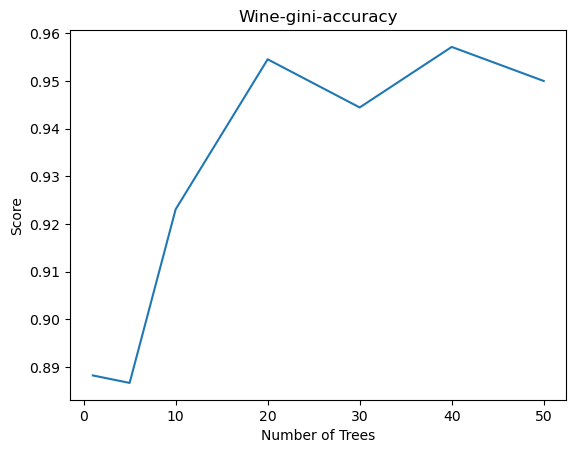

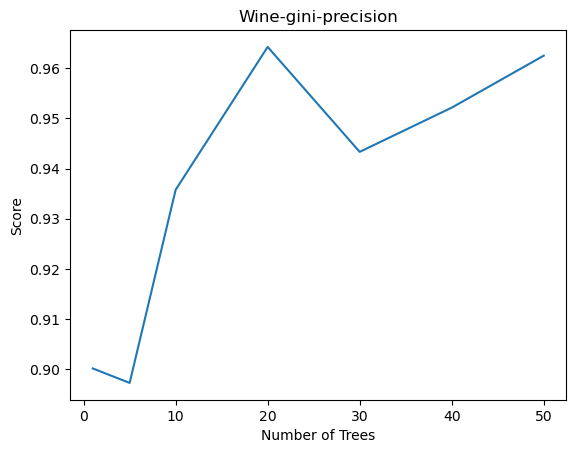

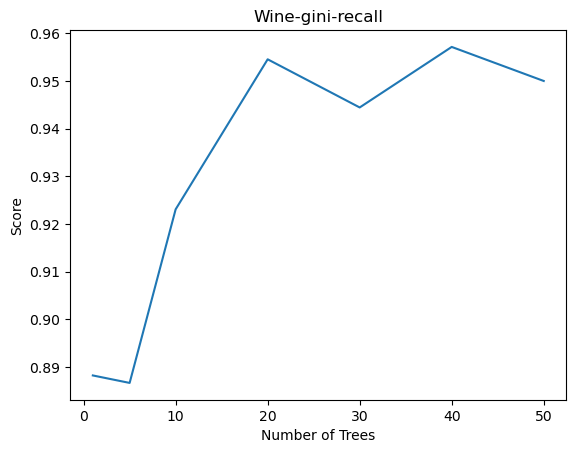

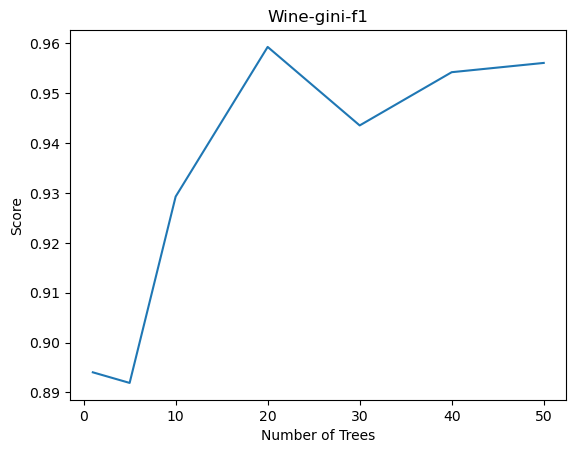

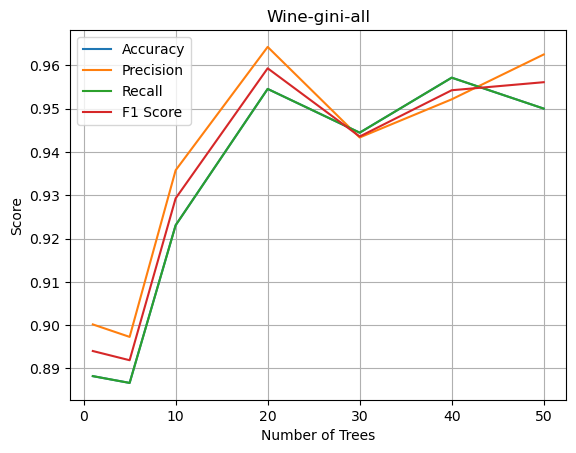

[0.8882352941176469, 0.8866666666666667, 0.9230769230769231, 0.9545454545454547, 0.9444444444444444, 0.9571428571428573, 0.95]
[0.9001750700280112, 0.8972936507936508, 0.9357692307692307, 0.9642424242424241, 0.9433333333333334, 0.9521428571428572, 0.9625]
[0.8882352941176469, 0.8866666666666667, 0.923076923076923, 0.9545454545454545, 0.9444444444444444, 0.9571428571428573, 0.95]
[0.8940322737414149, 0.8919042129251835, 0.9292849409025429, 0.9593082515756601, 0.943557078254934, 0.9542388758782202, 0.9560975609756097]


In [13]:
train_data = pd.read_csv('hw3_wine.csv', delimiter='\t')
# train_data, test_data = train_test_split(wine_data, test_size=0.3, random_state=42)
x_train, y_train = train_data.iloc[:, 1:].values, train_data.iloc[:, 0].values
# x_test, y_test = test_data.iloc[:, 1:].values, test_data.iloc[:, 0].values

#Converting labels to integers
y_train = y_train.astype(int)
# y_test = y_test.astype(int)


k = 10

avg_acc_arr = []
avg_prec_arr = []
avg_recall_arr = []
avg_f1_arr = []

x_axis = [1, 5, 10, 20, 30, 40, 50]

for n in x_axis:
    k_folds_x, k_folds_y = k_splits(k, x_train, y_train)
    acc_arr = []
    prec_arr = []
    recall_arr = []
    f1_arr = []

    for i in range(k):
        x_train = np.array([x for j, x in enumerate(k_folds_x) if j != i])
        y_train = np.array([y for j, y in enumerate(k_folds_y) if j != i])
        x_train = np.concatenate(x_train)
        y_train = np.concatenate(y_train)
        x_test = k_folds_x[i]
        y_test = k_folds_y[i]
        rf = RandomForest(n, [i for i in range(13)], [1, 2, 3], min_samples=5, max_depth=50)
        rf.fit(x_train, y_train, entropy)
        preds = rf.predict(x_test)
        acc_arr.append(rf.accuracy(y_test, preds))
        prec_arr.append(rf.precision(y_test, preds))
        recall_arr.append(rf.recall(y_test, preds))
        f1_arr.append(rf.f1_score(y_test, preds))
    
    avg_acc_arr.append(np.mean(acc_arr))
    avg_prec_arr.append(np.mean(prec_arr))
    avg_recall_arr.append(np.mean(recall_arr))
    avg_f1_arr.append(np.mean(f1_arr))

plt.plot(x_axis, avg_acc_arr, label='Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Wine-gini-accuracy')
plt.savefig('wine_gini_accuracy.png')
plt.show()

plt.plot(x_axis, avg_prec_arr, label='Precision')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Wine-gini-precision')
plt.savefig('wine_gini_precision.png')
plt.show()

plt.plot(x_axis, avg_recall_arr, label='Recall')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Wine-gini-recall')
plt.savefig('wine_gini_recall.png')
plt.show()

plt.plot(x_axis, avg_f1_arr, label='F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Wine-gini-f1')
plt.savefig('wine_gini_f1.png')
plt.show()

plt.plot(x_axis, avg_acc_arr, label='Accuracy')
plt.plot(x_axis, avg_prec_arr, label='Precision')
plt.plot(x_axis, avg_recall_arr, label='Recall')
plt.plot(x_axis, avg_f1_arr, label='F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.title('Wine-gini-all')
plt.savefig('wine_gini_all.png')
plt.show()
print(avg_acc_arr)
print(avg_prec_arr)
print(avg_recall_arr)
print(avg_f1_arr)




### The voting dataset (using Gini)

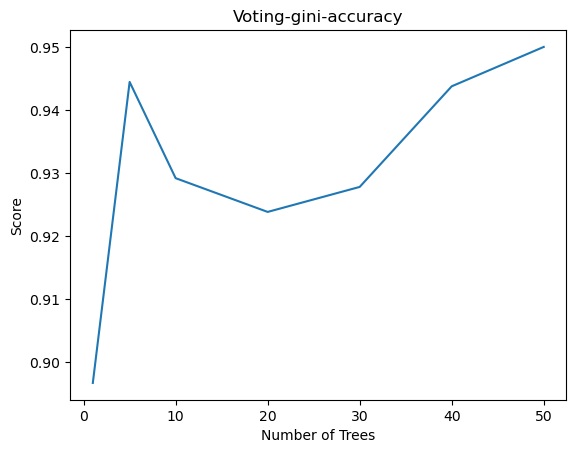

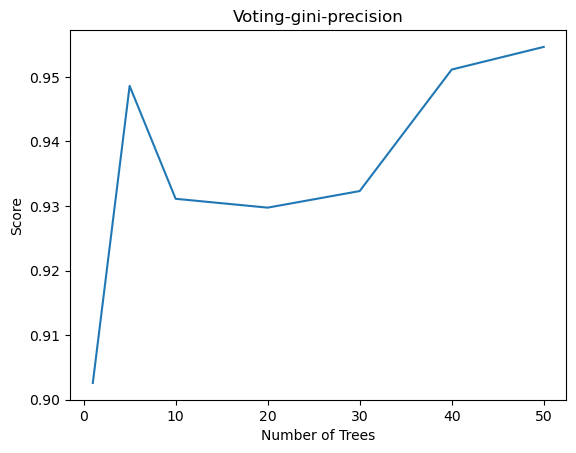

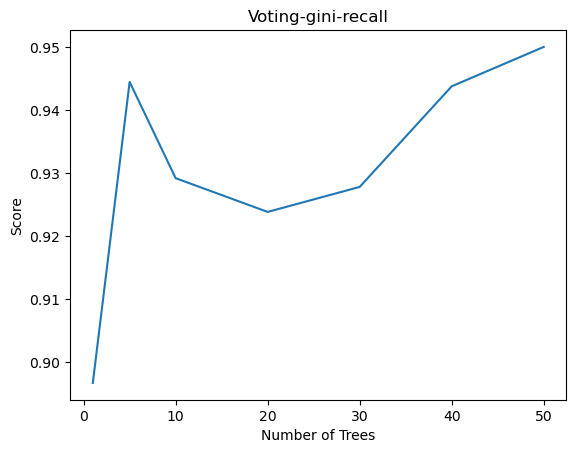

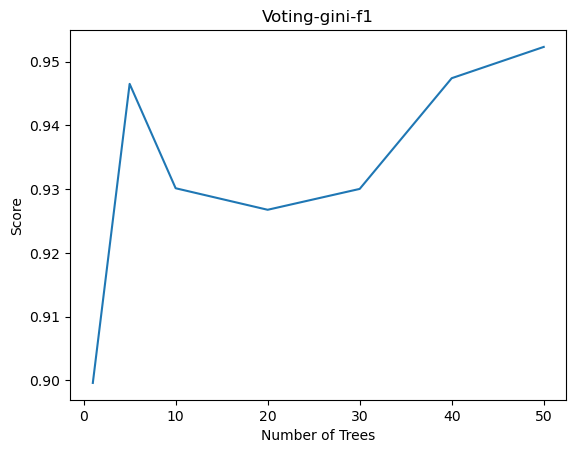

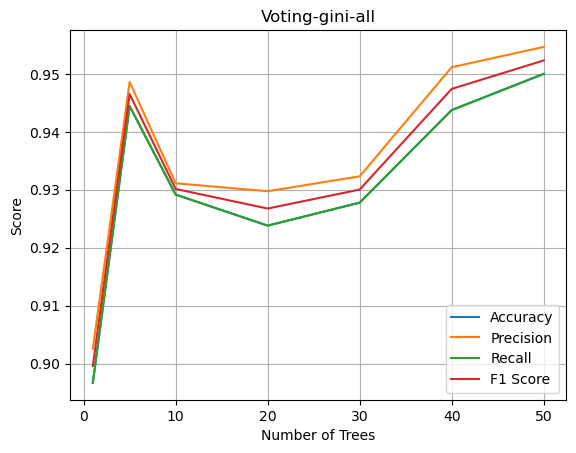

[0.8966666666666667, 0.9444444444444444, 0.9291666666666666, 0.9238095238095239, 0.9277777777777778, 0.94375, 0.95]
[0.9025895982242732, 0.9486076196860511, 0.9311167767417767, 0.9297477522477522, 0.9323152156485491, 0.951144255050505, 0.9546485260770975]
[0.8966666666666667, 0.9444444444444444, 0.9291666666666668, 0.9238095238095239, 0.9277777777777778, 0.94375, 0.95]
[0.8995902431714093, 0.9465149330847616, 0.9301378366793193, 0.9267589436631273, 0.9300326557696318, 0.9474059948199276, 0.9523125217997908]


In [14]:
voting_data = pd.read_csv('hw3_house_votes_84.csv')
train_data, test_data = train_test_split(voting_data, test_size=0.3, random_state=42)
x_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
x_test, y_test = test_data.iloc[:, -1:].values, test_data.iloc[:, -1].values


k = 10

avg_acc_arr = []
avg_prec_arr = []
avg_recall_arr = []
avg_f1_arr = []

x_axis = [1, 5, 10, 20, 30, 40, 50]

for n in [1, 5, 10, 20, 30, 40, 50]:
    k_folds_x, k_folds_y = k_splits(k, x_train, y_train)
    acc_arr = []
    prec_arr = []
    recall_arr = []
    f1_arr = []

    for i in range(k):
        x_train = np.array([x for j, x in enumerate(k_folds_x) if j != i])
        y_train = np.array([y for j, y in enumerate(k_folds_y) if j != i])
        x_train = np.concatenate(x_train)
        y_train = np.concatenate(y_train)
        x_test = k_folds_x[i]
        y_test = k_folds_y[i]
        rf = RandomForest(n, [i for i in range(13)], [0, 1], max_depth=500)
        rf.fit(x_train, y_train, entropy)
        preds = rf.predict(x_test)
        acc_arr.append(rf.accuracy(y_test, preds))
        prec_arr.append(rf.precision(y_test, preds))
        recall_arr.append(rf.recall(y_test, preds))
        f1_arr.append(rf.f1_score(y_test, preds))
    
    avg_acc_arr.append(np.mean(acc_arr))
    avg_prec_arr.append(np.mean(prec_arr))
    avg_recall_arr.append(np.mean(recall_arr))
    avg_f1_arr.append(np.mean(f1_arr))


plt.plot(x_axis, avg_acc_arr, label='Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Voting-gini-accuracy')
plt.savefig('voting_gini_accuracy.png')
plt.show()

plt.plot(x_axis, avg_prec_arr, label='Precision')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Voting-gini-precision')
plt.savefig('voting_gini_precision.png')
plt.show()

plt.plot(x_axis, avg_recall_arr, label='Recall')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Voting-gini-recall')
plt.savefig('voting_gini_recall.png')
plt.show()

plt.plot(x_axis, avg_f1_arr, label='F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Voting-gini-f1')
plt.savefig('voting_gini_f1.png')
plt.show()

plt.plot(x_axis, avg_acc_arr, label='Accuracy')
plt.plot(x_axis, avg_prec_arr, label='Precision')
plt.plot(x_axis, avg_recall_arr, label='Recall')
plt.plot(x_axis, avg_f1_arr, label='F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.title('Voting-gini-all')
plt.savefig('voting_gini_all.png')
plt.show()
print(avg_acc_arr)
print(avg_prec_arr)
print(avg_recall_arr)
print(avg_f1_arr)



### Performance Vs n-trees

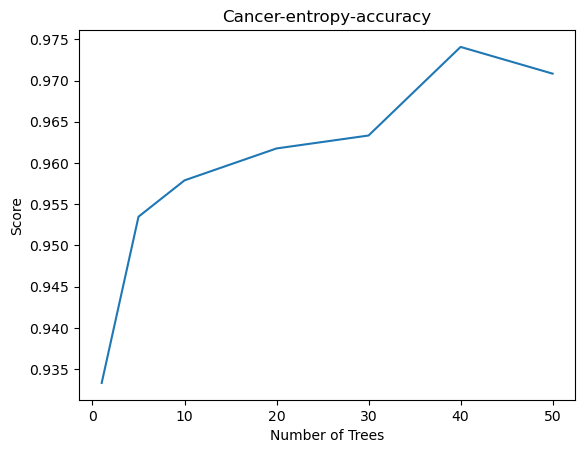

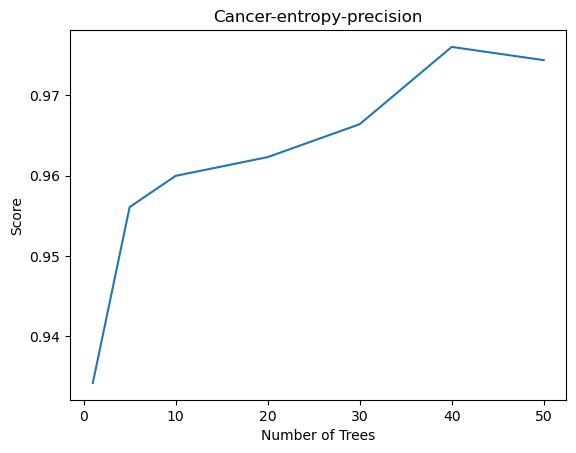

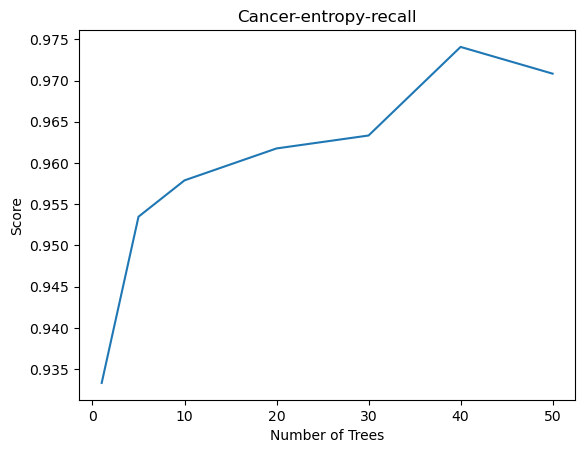

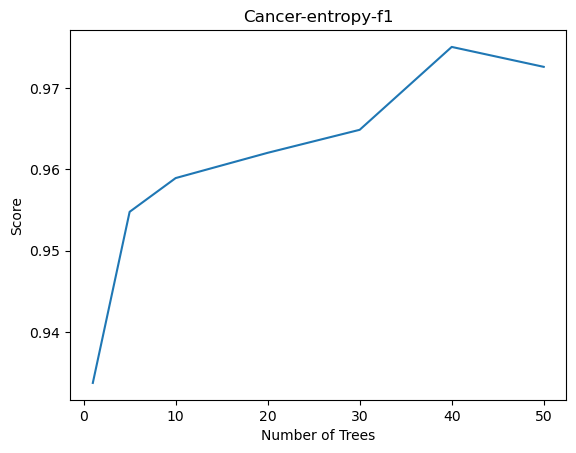

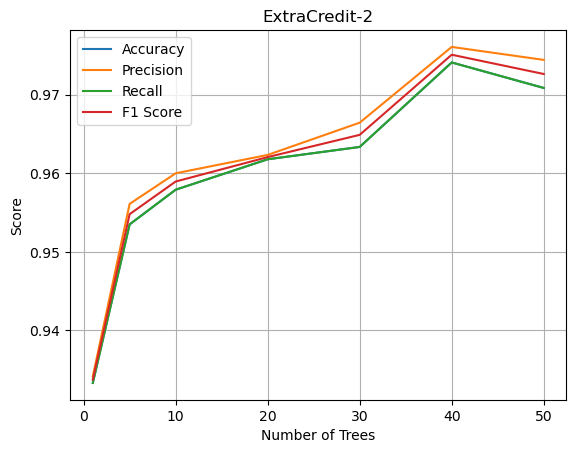

[0.9333333333333333, 0.9534883720930232, 0.9578947368421051, 0.9617647058823529, 0.9633333333333335, 0.9740740740740741, 0.9708333333333334]
[0.9341822833599152, 0.95609308839815, 0.9599824561403508, 0.962318563789152, 0.9664177270098323, 0.9760488240880397, 0.9744002525252526]
[0.9333333333333333, 0.9534883720930234, 0.9578947368421051, 0.9617647058823529, 0.9633333333333335, 0.9740740740740741, 0.9708333333333334]
[0.9337570132573211, 0.9547872184952986, 0.9589357301537635, 0.9620413617131159, 0.9648695079187197, 0.9750573471475933, 0.97260750830709]


In [16]:
data = pd.read_csv('hw3_cancer.csv', delimiter='\t')
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
x_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
x_test, y_test = test_data.iloc[:, -1:].values, test_data.iloc[:, -1].values


k = 10

x_axis = [1, 5, 10, 20, 30, 40, 50]

avg_acc_arr = []
avg_prec_arr = []
avg_recall_arr = []
avg_f1_arr = []

for n in [1, 5, 10, 20, 30, 40, 50]:
    k_folds_x, k_folds_y = k_splits(k, x_train, y_train)
    acc_arr = []
    prec_arr = []
    recall_arr = []
    f1_arr = []

    for i in range(k):
        x_train = np.array([x for j, x in enumerate(k_folds_x) if j != i])
        y_train = np.array([y for j, y in enumerate(k_folds_y) if j != i])
        x_train = np.concatenate(x_train)
        y_train = np.concatenate(y_train)
        x_test = k_folds_x[i]
        y_test = k_folds_y[i]
        rf = RandomForest(n, [i for i in range(9)], [0, 1])
        rf.fit(x_train, y_train, entropy)
        preds = rf.predict(x_test)
        acc_arr.append(rf.accuracy(y_test, preds))
        prec_arr.append(rf.precision(y_test, preds))
        recall_arr.append(rf.recall(y_test, preds))
        f1_arr.append(rf.f1_score(y_test, preds))
    
    avg_acc_arr.append(np.mean(acc_arr))
    avg_prec_arr.append(np.mean(prec_arr))
    avg_recall_arr.append(np.mean(recall_arr))
    avg_f1_arr.append(np.mean(f1_arr))

plt.plot(x_axis, avg_acc_arr, label='Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Cancer-entropy-accuracy')
plt.savefig('cancer_entropy_accuracy.png')
plt.show()

plt.plot(x_axis, avg_prec_arr, label='Precision')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Cancer-entropy-precision')
plt.savefig('cancer_entropy_precision.png')
plt.show()

plt.plot(x_axis, avg_recall_arr, label='Recall')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Cancer-entropy-recall')
plt.savefig('cancer_entropy_recall.png')
plt.show()

plt.plot(x_axis, avg_f1_arr, label='F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Cancer-entropy-f1')
plt.savefig('cancer_entropy_f1.png')
plt.show()

plt.plot(x_axis, avg_acc_arr, label='Accuracy')
plt.plot(x_axis, avg_prec_arr, label='Precision')
plt.plot(x_axis, avg_recall_arr, label='Recall')
plt.plot(x_axis, avg_f1_arr, label='F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.title('Performance Vs n-trees')
plt.savefig('extra_credit_2.png')
plt.show()
print(avg_acc_arr)
print(avg_prec_arr)
print(avg_recall_arr)
print(avg_f1_arr)



### Performance Vs n-trees

In [17]:
from ucimlrepo import fetch_ucirepo 
# fetch dataset 
contraceptive_method_choice = fetch_ucirepo(id=30) 
# data (as pandas dataframes) 
X = contraceptive_method_choice.data.features
Y = contraceptive_method_choice.data.targets
#Adding Y to X as the last column
X['Y'] = Y
data = X
np.bincount(data.iloc[:, -1].to_numpy())


array([  0, 629, 333, 511], dtype=int64)

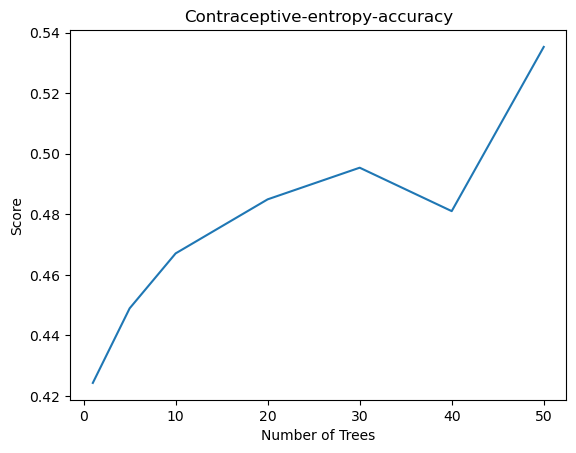

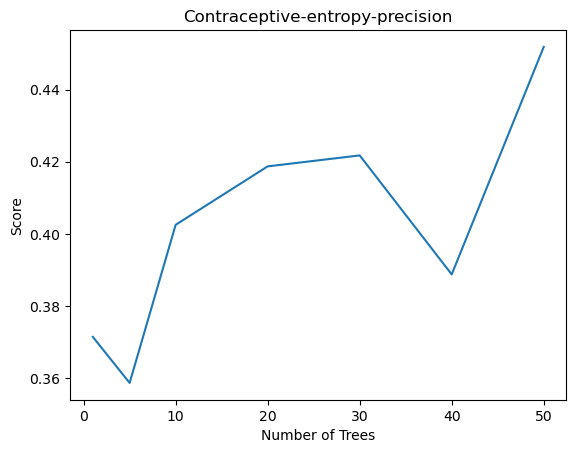

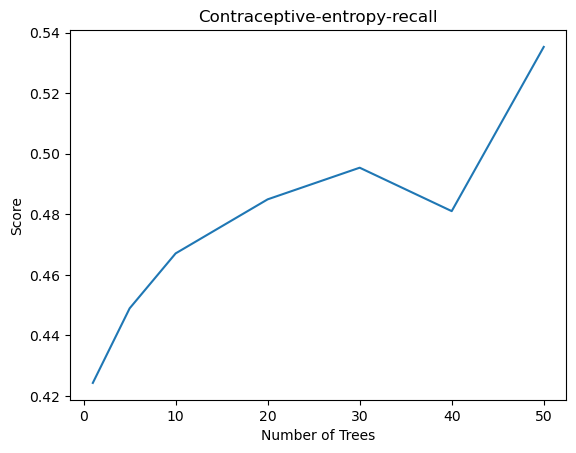

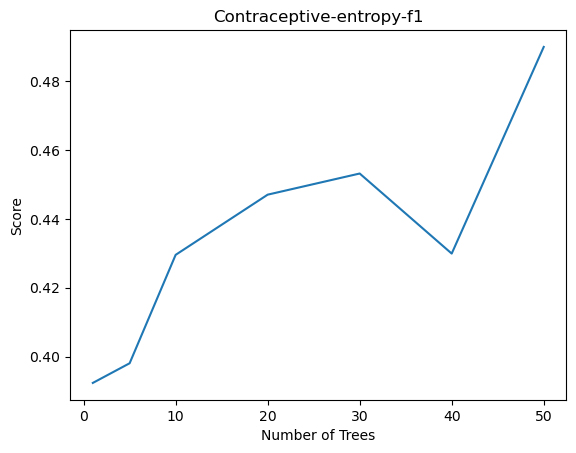

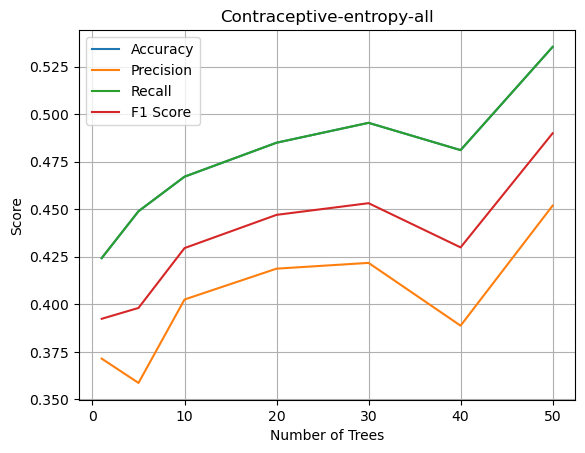

[0.4242718446601942, 0.44891304347826094, 0.46707317073170734, 0.4849315068493151, 0.4953846153846154, 0.48103448275862065, 0.5352941176470588]
[0.37142318471349417, 0.358648540950888, 0.4025066397503573, 0.4187203367643564, 0.4217574988555583, 0.38874989968646034, 0.4518538475557829]
[0.4242718446601942, 0.44891304347826094, 0.46707317073170723, 0.4849315068493151, 0.4953846153846154, 0.48103448275862065, 0.5352941176470588]
[0.3923604422513264, 0.3980687023365647, 0.4295322227162627, 0.44700356134396985, 0.4531396394666605, 0.42989928009122125, 0.48988636909734523]


In [20]:
data = sklearn.utils.shuffle(data)
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
x_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
x_test, y_test = test_data.iloc[:, -1:].values, test_data.iloc[:, -1].values


k = 10
x_axis = [1, 5, 10, 20, 30, 40, 50]

avg_acc_arr = []
avg_prec_arr = []
avg_recall_arr = []
avg_f1_arr = []

for n in [1, 5, 10, 20, 30, 40, 50]:
    k_folds_x, k_folds_y = k_splits(k, x_train, y_train)
    acc_arr = []
    prec_arr = []
    recall_arr = []
    f1_arr = []

    for i in range(k):
        x_train = np.array([x for j, x in enumerate(k_folds_x) if j != i])
        y_train = np.array([y for j, y in enumerate(k_folds_y) if j != i])
        x_train = np.concatenate(x_train)
        y_train = np.concatenate(y_train)
        x_test = k_folds_x[i]
        y_test = k_folds_y[i]
        rf = RandomForest(n, [i for i in range(9)], [1,2,3], max_depth=100)
        rf.fit(x_train, y_train, entropy)
        preds = rf.predict(x_test)
        acc_arr.append(rf.accuracy(y_test, preds))
        prec_arr.append(rf.precision(y_test, preds))
        recall_arr.append(rf.recall(y_test, preds))
        f1_arr.append(rf.f1_score(y_test, preds))
    
    avg_acc_arr.append(np.mean(acc_arr))
    avg_prec_arr.append(np.mean(prec_arr))
    avg_recall_arr.append(np.mean(recall_arr))
    avg_f1_arr.append(np.mean(f1_arr))

plt.plot(x_axis, avg_acc_arr, label='Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Contraceptive-entropy-accuracy')
plt.savefig('contraceptive_entropy_accuracy.png')
plt.show()

plt.plot(x_axis, avg_prec_arr, label='Precision')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Contraceptive-entropy-precision')
plt.savefig('contraceptive_entropy_precision.png')
plt.show()

plt.plot(x_axis, avg_recall_arr, label='Recall')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Contraceptive-entropy-recall')
plt.savefig('contraceptive_entropy_recall.png')
plt.show()

plt.plot(x_axis, avg_f1_arr, label='F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Contraceptive-entropy-f1')
plt.savefig('contraceptive_entropy_f1.png')
plt.show()

plt.plot(x_axis, avg_acc_arr, label='Accuracy')
plt.plot(x_axis, avg_prec_arr, label='Precision')
plt.plot(x_axis, avg_recall_arr, label='Recall')
plt.plot(x_axis, avg_f1_arr, label='F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.title('Contraceptive-entropy-all')
plt.savefig('contraceptive_entropy_all.png')
plt.show()
print(avg_acc_arr)
print(avg_prec_arr)
print(avg_recall_arr)
print(avg_f1_arr)

